In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

%matplotlib inline
plt.style.use('fivethirtyeight')


# Comparing Two Samples Using Hypothesis Tests

## A/B Testing: Example 1

Recall the baby dataset from our lesson on visualization.  In that particular medical study, a sample of newborn babies was obtained from a large hospital system.  We will treat the data as if it were a simple random sample, though the sampling was done in multiple stages. Deborah Nolan and Terry Speed discuss the larger dataset in [Stat Labs](https://www.stat.berkeley.edu/~statlabs/).

One of the aims of the study was to see whether maternal smoking was associated with birth weight.

In [2]:
births_df = pd.read_csv("data/baby.csv")

births_df.head()

,Birth Weight,Gestational Days,Maternal Age,Maternal Height,Maternal Pregnancy Weight,Maternal Smoker
0,120,284,27,62,100,False
1,113,282,33,64,135,False
2,128,279,28,64,115,True
3,108,282,23,67,125,True
4,136,286,25,62,93,False


In [ ]:
# Determine the number of mothers in the study who smoked vs who didn't:

(births_df[["Maternal Smoker", "Birth Weight"]].groupby("Maternal Smoker")
                                                .count()
                                                 .rename(columns = {"Birth Weight": "Count"})
)

# Comparing Two Samples

In [ ]:
sns.histplot(births_df, x="Birth Weight", hue="Maternal Smoker");
plt.title("Distribution of Birth Weight");

In [ ]:
px.box(births_df, x = 'Maternal Smoker', y = 'Birth Weight',width=600)

The distribution of the weights of the babies born to mothers who smoked appears to be shifted slightly lower than the distribution corresponding to non-smoking mothers. The weights of the babies of the mothers who smoked seem lower on average than the weights of the babies of the non-smokers.


<br/>

Similar to the original study, we'd like to study whether this difference reflects just chance variation or perhaps a difference in the distributions in the larger population. Suppose we propose the following two hypotheses:

> **Null hypothesis**: In the population, the distribution of birth weights of babies is the same for mothers who don’t smoke as for mothers who do. The (observed) difference in the sample is due to chance.

> **Alternative hypothesis**: In the population, the babies of the mothers who smoke have a <i>**lower**</i> birth weight, on average, than the babies of the non-smokers.

We would like to perform hypothesis testing using the permutation test. One way to do so is to compute an observed test statistic and then compare it with multiple simulated test statistics, generated through random permutations.

# Test Statistic

<br/>

---

### Question 1b

Suppose that we choose a reasonable test statistic as the difference between the average birth weights of the two groups (i.e., the **average weights of babies of smokers minus the average weights babies of non-smokers**). 

What values of our statistic are in favor of the alternative: positive or negative?: **Negative**



Fill in the function below to create a function that calculates the difference in means for 2 different categories.


In [3]:
def difference_of_means(df, numeric_label, category_label, absol=False):
    """
    Takes: 
       - name of DataFrame
       - column label of numerical variable (i.e. is the weights of the babies)
       - column label of boolean variable (i.e. is whether they smoked or not)
       
    Returns: Difference of means of the two groups
    """  
    #df with the two relevant columns
    reduced = df[[numeric_label, category_label]]  
    
    # df containing group means
    means_df = reduced.groupby(category_label).mean().rename(columns = {numeric_label: numeric_label+" Mean"})
    
    #print(means_df)
    
    if absol==True:
        return abs(means_df.iloc[1,0]-means_df.iloc[0,0])
    else:
        return means_df.loc[True, numeric_label+" Mean"] - means_df.loc[False, numeric_label+" Mean"]


In the below cell, assign `observed_difference` to the **observed test statistic** given our original sample of `nonsmoker_births` and `smoker_births`.


In [ ]:
observed_difference = difference_of_means(births_df, 'Birth Weight', 'Maternal Smoker')
observed_difference

# Random Permutation (Shuffling)

<!-- BEGIN QUESTION -->

<br/>

---
Before we write any code, let’s explain the idea of hypothesis testing with the permutation test. We first simulate the experiment many times (say, 10,000 times) through random permutation (i.e. without replacement). Assuming that the null hypothesis holds, this process will produce an empirical distribution of a predetermined test statistic. Then, we use this empirical distribution to compute an empirical p-value, which is then compared against a particular cutoff threshold in order to accept or reject our null hypothesis. 


Below is a simple example to show how to conduct random permuations in Python.  We use a toy dataframe of just a few names so it's easier to see how this works before we apply it to our original baby dataset.

In [ ]:
#Toy DataFrame to demonstrate how to code permuatations in Python
staff = pd.DataFrame(
    {       
        'Groups': ['Label 1', 'Label 1', 'Label 2', 'Label 2', 'Label 2'],
         'Ages': [29, 28, 34, 41, 51]
        
    }
)

staff

In [ ]:
staff.sample()

In [ ]:
staff.sample(3)  #Default is without replacement

In [ ]:
staff.sample(frac=1)  

#frac is the fraction of the original dataset that you want to sample.  
# The default is without replacement (which we want when doing permutations)

In [ ]:
# Add a column to our original dataframe with the name labels shuffled 

shuffled_labels = staff["Groups"].sample(frac=1, replace=False).values
original_with_shuffled_labels = staff.copy()
original_with_shuffled_labels["Shuffled Label"] = shuffled_labels
original_with_shuffled_labels



# Simulation Under Null Hypothesis:  Permutation Test

<!-- END QUESTION -->

<br/>

---

### Question 1c

We start by creating a function that simulates the difference in means for one random permutation of the data.

In [4]:
def one_simulated_difference(df, numeric_label, category_label,absol=False, print_ex=False):
    """
    Takes: 
       - name of table
       - column label of numerical variable
       - column label of categorical variable
       
    Returns: Difference of means of the two groups
    """
    
    # array of shuffled labels
    shuffled_labels = df[category_label].sample(frac=1, replace=False).values
    
    # table of numerical variable and shuffled labels
    
    original_with_shuffled=df.copy()
    original_with_shuffled["Shuffled Label"] = shuffled_labels
    
    if print_ex==True:
        print(original_with_shuffled[[numeric_label, category_label,"Shuffled Label"]])
    
    
    if absol==True:
        return difference_of_means(original_with_shuffled, numeric_label, 'Shuffled Label', absol=True)   
    else:
        return difference_of_means(original_with_shuffled, numeric_label, 'Shuffled Label')   
    
    

In [ ]:
one_simulated_difference(births_df,"Birth Weight", "Maternal Smoker", print_ex=True)


<br/>

---

### Question 1d

Repeat this process for n=10000 simulations and graph the empirical histogram of the difference in means:

In [ ]:
repetitions = 10000


simulated_statistics_ab = np.array([one_simulated_difference(births_df,"Birth Weight", "Maternal Smoker") for i in range(repetitions)]) # SOLUTION


plt.hist(simulated_statistics_ab, density = True, ec="white")
plt.xlabel('Difference in average weights')
plt.ylabel('Percent per Unit')
plt.title('Prediction Under the Null Hypothesis')
#Plot a point with the observed test statistic
plt.scatter(observed_difference, -0.002, color='red', s=70);




<!-- END QUESTION -->

<br/>

---

### Question 1e

Compute `empirical_p`, the empirical p-value based on `simulated_statistics_ab` (the empirical distribution of the test statistic) and `observed_difference` (the observed value of the test statistic).


In [ ]:
empirical_p = np.count_nonzero(simulated_statistics_ab<= observed_difference) / len(simulated_statistics_ab)
empirical_p


<!-- BEGIN QUESTION -->

<br/>

---

### CONCLUSION OF TEST:  Question 1f

Based on this computed empirical p-value, and our pre-determined significance level of 0.01, do we accept or reject the null hypothesis? 

**SOLUTION**: The empirical p-value is 0, meaning that none of the 10,000 permuted samples resulted in a difference of -9.27 or lower. **This is only an approximation. The exact chance of getting a difference in that range is not 0.** But it is vanishingly small, according to our simulation, therefore $p<=0.01$, so we  **reject the null hypothesis and accept the alternative hypothesis** and our test results are highly statistically significant.



"In the population, the babies of the mothers who smoke have a lower birth weight, on average, than the babies of the non-smokers and this result is highly statistically significant"


Since this was an observational study (NOT a randomized control trial) we CANNOT conclude that smoking causes the lower birth rate, only that there was an association between the two. 



In [ ]:
# Notice, if we look at other variables in the dataset, it is possible that one of the other variables
# had a casual relationship with Birth Weight.  There is no way to make a casual conclusion without
# doing a randomized controlled trial, which we can't ethically do in this situation.

births_df.groupby("Maternal Smoker").mean()

# Randomized Controlled Trials



Our methods for comparing two samples have a powerful use in the analysis of randomized controlled experiments. Since the treatment and control groups are assigned randomly in such experiements, differences in their outcomes can be compared to what would happen just due to chance if the treatment had no effect at all. If the observed differences are more marked than what we would predict as purely due to chance, we will have evidence of causation. Because of the unbiased assignment of individuals to the treatment and control groups, differences in the outcomes of the two groups can be ascribed to the treatment.

The key to the analysis of randomized controlled experiments is understanding exactly how chance enters the picture. This helps us set up clear null and alternative hypotheses. Once that’s done, we can simply use the methods of the previous sections to complete the analysis.






## Example 2: Treating Low Back Pain



Low-back pain in adults can be very persistent and hard to treat. Common methods run the gamut from corticosteroids to acupuncture. A randomized controlled trial (RCT) (https://pubmed.ncbi.nlm.nih.gov/11376175/) examined the effect of using Botulinum Toxin A (BTA) as a treatment. Botulinum toxin is a neurotoxic protein that causes the disease botulism; Wikipedia says that botulinum “is the most acutely lethal toxin known.” There are seven types of botulinum toxin. Botulinum Toxin A is one of the types that can cause disease in humans, but it is also used in medicine to treat various diseases involving the muscles. The RCT analyzed by Foster, Clapp, and Jabbari in 2001 examined it as a treatment for low back pain.


Thirty one patients with low-back pain were randomized into treatment and control groups, with 15 in the treatment group and 16 in control. The control group was given normal saline, and the trials were run double-blind so that neither doctors nor patients knew which group they were in.



Eight weeks after the start of the study, nine of the 15 in the treatment group and two of the 16 in the control group had pain relief (according to a precise definition used by the researchers). These data are in the file `bta.csv` and appear to show that the treatment has a clear benefit.

In [6]:
botox = pd.read_csv('data/bta.csv')
botox

,Group,Result
0,Control,1.0
1,Control,1.0
2,Control,0.0
3,Control,0.0
4,Control,0.0
5,Control,0.0
6,Control,0.0
7,Control,0.0
8,Control,0.0
9,Control,0.0


### Null and Alternative Hypotheses and Significance Level:

**Null Hypothesis:** The distribution of all 31 potential “treatment” outcomes is the same as that of all 31 potential “control” outcomes. Botulinum toxin A does nothing different from saline; the difference in the two samples is just due to chance.

**Alternative Hypothesis:** The distribution of 31 potential “treatment” outcomes is different from that of the 31 control outcomes. The treatment does something different from the control.



**Significance Level:** As is standard with medical studies, we will test this at a significance level of $\alpha = 0.01$

###  Choosing Test Statistic:


Notice that the alternative is not specifying that the treatment helps – just that it is different from the control. This is standard in medical studies because it doesn’t pre-judge which way the result might go. 

Notice the outcome is binary (either it helps (1) or it didn't (0)).


Because of this, the following three test statistics are all equivalent:
 - TVD: sum(abs(dist1-dist2))/2
 - Absolute difference in proportion of successes: abs(group1prop - group2prop)
 - Absolute difference in the mean of the binary data from both distributions:  abs(group1mean - group2mean)

In the code below we'll calculate this using the last format, but notice that this is equivalent to using the TVD:  **abs(treatment_mean - control_mean)**

### Collect data and calculate observed test statistic:



In [7]:
botox.groupby(['Group', 'Result']).value_counts()

Group      Result
Control    0.0       14
           1.0        2
Treatment  0.0        6
           1.0        9
Name: count, dtype: int64

In [8]:
botox.groupby('Group').agg({"Result":"mean"})

,Result
Group,
Control,0.125
Treatment,0.600


In [9]:
#Use difference of proportions of people who had pain relief (Result=1) as the test statistic

#Notice for binary data, proportion of 1's = mean

#Calculate the observed test statistic.


#observed_diff = abs(botox.groupby('Group').agg({"Result":"mean"}).iloc[1,0] - botox.groupby('Group').agg({"Result":"mean"}).iloc[0,0])
    
#observed_diff


# Or we can just use our function above
observed_diff = difference_of_means(botox, 'Result', 'Group',absol=True)

observed_diff


0.475

In [10]:
# Shuffle:

shuffled_labels = botox["Group"].sample(frac=1, replace=False).values
    
# table of numerical variable and shuffled labels
    
original_with_shuffled=botox.copy()
original_with_shuffled["Shuffled Label"] = shuffled_labels
    
#print (original_with_shuffled)

# Calculate test statistic using shuffled labels:

test_stat = abs(original_with_shuffled.groupby('Shuffled Label')["Result"].mean()[1] - botox.groupby('Group')["Result"].mean()[0])
    
print ("Simulated test statistic is:", test_stat)



# Or we could have done all of these steps just using our function above:
#one_simulated_difference(botox, 'Result', 'Group',print_ex=True, absol=True)

Simulated test statistic is: 0.14166666666666666


In [12]:
one_simulated_difference(botox, 'Result', 'Group',print_ex=True, absol=True)

    Result      Group Shuffled Label
0      1.0    Control        Control
1      1.0    Control      Treatment
2      0.0    Control      Treatment
3      0.0    Control      Treatment
4      0.0    Control      Treatment
5      0.0    Control        Control
6      0.0    Control      Treatment
7      0.0    Control        Control
8      0.0    Control        Control
9      0.0    Control      Treatment
10     0.0    Control        Control
11     0.0    Control        Control
12     0.0    Control        Control
13     0.0    Control      Treatment
14     0.0    Control        Control
15     0.0    Control        Control
16     1.0  Treatment        Control
17     1.0  Treatment        Control
18     1.0  Treatment        Control
19     1.0  Treatment        Control
20     1.0  Treatment      Treatment
21     1.0  Treatment      Treatment
22     1.0  Treatment      Treatment
23     1.0  Treatment      Treatment
24     1.0  Treatment      Treatment
25     0.0  Treatment      Treatment
2

0.08750000000000002

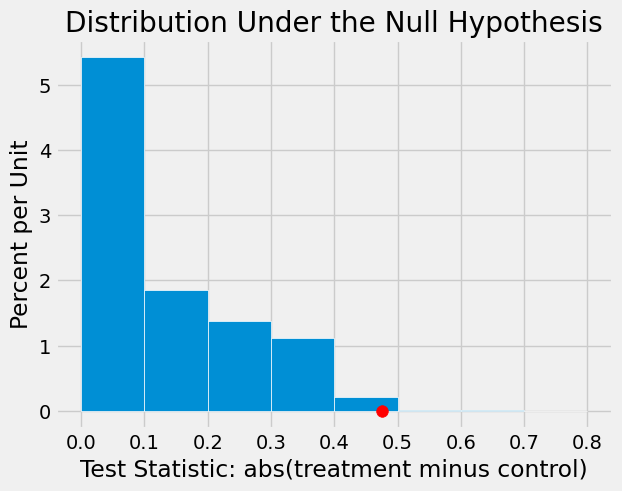

In [13]:
#Repeat simulations and plot empirical histogram of test statistic:

repetitions = 100000


simulated_diffs = np.array([one_simulated_difference(botox, 'Result', 'Group', absol=True) for i in range(repetitions)]) # SOLUTION


plt.hist(simulated_diffs, density = True, ec="white", bins=[0,.1,.2,.3,.4,.5,.6,.7,.8])
plt.xlabel('Test Statistic: abs(treatment minus control)')
plt.ylabel('Percent per Unit')
plt.title('Distribution Under the Null Hypothesis')
#Plot a point with the observed test statistic
plt.scatter(observed_diff, -0.002, color='red', s=70);

### Calculate p-value and make conclusion from test

In [18]:
# p-value
sum(simulated_diffs >= observed_diff)/len(simulated_diffs)

This is a small empirical p-value. The observed statistic is in the tail of the empirical histogram of the test statistic generated under the null hypothesis.

Since $p \leq .01$ the result is highly statistically significant. The test favors the alternative hypothesis over the null. The evidence supports the hypothesis that the treatment is doing something.

The actual study reports a P-value of 0.009, or 0.9%, which is very close to our empirical value.

## Note about Causality
Because the trials were randomized, the test is **evidence that the treatment causes the difference.** The random assignment of patients to the two groups ensures that there is no confounding variable that could affect the conclusion of causality.

If the treatment had not been randomly assigned, our test would still point toward an association between the treatment and back pain outcomes among our 31 patients. But beware: without randomization, this association would not imply that the treatment caused a change in back pain outcomes. For example, if the patients themselves had chosen whether to administer the treatment, perhaps the patients experiencing more pain would be more likely to choose the treatment and more likely to experience some reduction in pain even without medication. Pre-existing pain would then be a confounding factor in the analysis.

## A Meta-Analysis
While the Randomized Control Trial does provide evidence that the botulinum toxin A treatment helped patients, **a study of 31 patients isn’t enough to establish the effectiveness of a medical treatment. This is not just because of the small sample size. Our results in this section are valid for the 31 patients in the study, but we are really interested in the population of all possible patients.**

In 2011, a group of researchers performed a meta-analysis of the studies on the treatment. That is, they identified all the available studies of such treatments for low-back pain and summarized the collated results.

There were several studies but not many could be included in a scientifically sound manner: “We excluded evidence from nineteen studies due to non-randomisation, incomplete or unpublished data.” Only three randomized controlled trials remained, one of which is the one we have studied in this section. The meta-analysis gave it the highest assessment among all the studies (LBP stands for low-back pain): “We identified three studies that investigated the merits of BoNT for LBP, but only one had a low risk of bias and evaluated patients with non-specific LBP (N = 31).”

**Putting it all together, the meta-analysis concluded, “There is low quality evidence that BoNT injections improved pain, function, or both better than saline injections and very low quality evidence that they were better than acupuncture or steroid injections. … Further research is very likely to have an important impact on the estimate of effect and our confidence in it. Future trials should standardize patient populations, treatment protocols and comparison groups, enlist more participants and include long-term outcomes, cost-benefit analysis and clinical relevance of findings.”**

It takes a lot of careful work to establish that a medical treatment has a beneficial effect. Knowing how to analyze randomized controlled trials is a crucial part of this work. Now that you know how to do that, you are well positioned to help medical and other professions establish cause-and-effect relations.

## The effect of simulation size on empirical p-values:

In [17]:
tests = pd.DataFrame(columns=['simulations', 'p-value for observed test statistic of 0.475'])
    
for num_sims in [1000, 10000, 20000, 100000]:
    for k in np.arange(10):
        sim = np.array([one_simulated_difference(botox, 'Result', 'Group', absol=True) for i in range(num_sims)]) # SOLUTION
        tests.loc[len(tests.index)] = [num_sims, sum(sim >= observed_diff)/num_sims] 
 
tests

,simulations,p-value for observed test statistic of 0.475
0,1000.0,0.01400
1,1000.0,0.01100
2,1000.0,0.01000
3,1000.0,0.00900
4,1000.0,0.01100
5,1000.0,0.00900
6,1000.0,0.00400
7,1000.0,0.00700
8,1000.0,0.00600
9,1000.0,0.00600


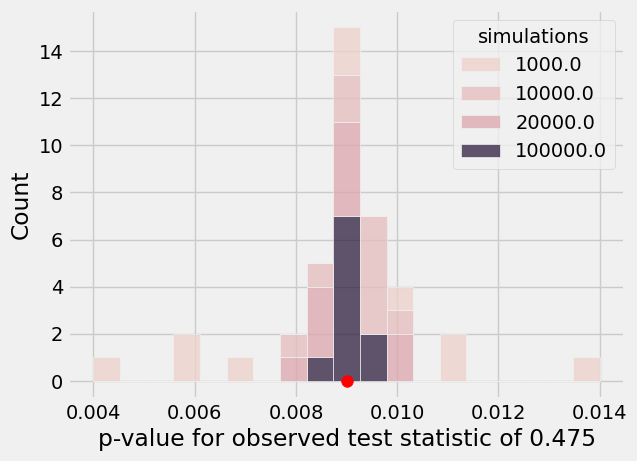

In [20]:
sns.histplot(data=tests, x="p-value for observed test statistic of 0.475", hue="simulations", multiple="stack")
plt.scatter(.009, -0.002, color='red', s=70);